In [1]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = (8.0, 10.0)

In [2]:
class DataGenerator(object):
    def __init__(self, annFile, dataDir):
        self._annFile = annFile
        self._dataDir = dataDir
        self._coco = COCO(annFile)
        
    def getBatch(self, n=100, imgIds=None, expandMasks=False):
        if imgIds is None:
            ids = self._coco.getImgIds()
            imgIds = ids[:n]
        
        imgs = self._coco.loadImgs(ids=imgIds)

        images = []
        labels = []
        for img in imgs:
            I = io.imread('{}/{}'.format(dataDir, img['file_name']))
            images.append(np.moveaxis(I, -1, 0))
            annIds = self._coco.getAnnIds(imgIds=img['id'])
            anns = self._coco.loadAnns(annIds)
            if expandMasks:
                res = np.zeros((max(self._coco.getCatIds()) + 1,
                                I.shape[0], I.shape[1]))
                for ann in anns:
                    mask = self._coco.annToMask(ann)
                    res[ann['category_id']] = np.where(
                        mask != 0,
                        mask,
                        res[ann['category_id']])

                labels.append(res)
            else:
                res = np.zeros((I.shape[0], I.shape[1]), dtype=np.int32)
                for ann in anns:
                    mask = self._coco.annToMask(ann) * ann['category_id']
                    res = np.where(
                        mask != 0,
                        mask,
                        res[ann['category_id']]
                    )
                labels.append(res)

        return images, labels
        

In [3]:
annFile = '../annotations/instances_train2017.json'
dataDir = '../train2017'

In [4]:
gen = DataGenerator(annFile, dataDir)

loading annotations into memory...
Done (t=14.85s)
creating index...
index created!


In [5]:
images, labels = gen.getBatch(50, expandMasks=True)
labels[0].shape

(91, 427, 640)

In [6]:
from torch import nn
from torch.autograd import Variable
import torch
from torchvision import transforms
from PIL import Image
from torchvision.models import vgg19_bn
import itertools

In [7]:
class VGGExtractor(nn.Module):
    def __init__(self):
        super(VGGExtractor, self).__init__()
        model = vgg19_bn(pretrained=True)
        self.first = nn.Sequential(*[model.features[i] for i in range(15)])
        self.second = nn.Sequential(*[model.features[i] for i in range(15, 28)])
        
        for param in model.parameters():
            param.requires_grad = False
    
    def forward(self, x):
        conv3_1 = self.first.forward(x)
        conv4_1 = self.second.forward(conv3_1)
        return conv3_1, conv4_1

In [8]:
trans = VGGExtractor()

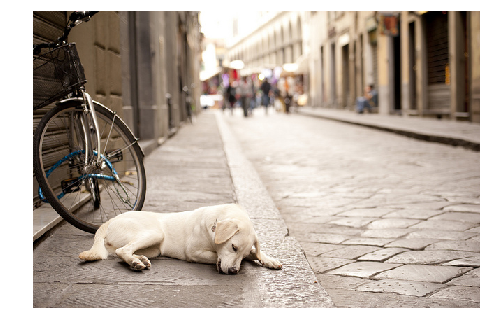

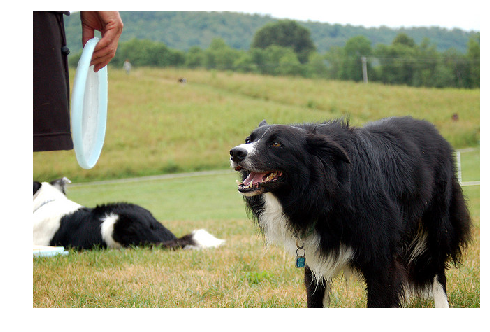

In [9]:
content = images[43]
style = images[2]
plt.figure(1)
plt.axis('off')
plt.imshow(np.moveaxis(content, 0, -1))

plt.figure(2)
plt.axis('off')

plt.imshow(np.moveaxis(style, 0, -1))
plt.show()

content_masks = labels[43]
style_masks = labels[2]
del labels
del images

In [10]:
def prepare_img(img):
    tens = torch.FloatTensor(img)
    return Variable(tens.contiguous().view(1, *tens.shape))

In [11]:
gen_img = np.random.randint(0, 255, content.shape, dtype=np.uint8)

In [13]:
style3_1, style4_1 = trans.forward(prepare_img(style))
cont3_1, cont4_1 = trans.forward(prepare_img(content))
gen3_1, gen4_1 = trans.forward(prepare_img(gen_img))
h, w = style3_1.shape[2:]

In [14]:
def downsample(imgs, sz):
    """Downsample a sequence of binary images to a given size."""
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(sz),
        transforms.ToTensor(),
    ])
    
    return torch.cat([transform(x.view((1, *x.shape))).view((1, 1, *sz)) for x in imgs], dim=1)
    

In [15]:
BETA = 20
content_masks_3_1 = BETA * downsample(torch.FloatTensor(content_masks), (h, w))
style_masks_3_1 = BETA * downsample(torch.FloatTensor(style_masks), (h, w))

In [16]:
style_masks_3_1.shape

torch.Size([1, 91, 106, 160])

In [17]:
content_loss = ((cont3_1 - gen3_1) ** 2).sum() + ((cont4_1 - gen4_1) ** 2).sum()

In [18]:
T = 3

In [19]:
s = torch.cat((style3_1, Variable(style_masks_3_1)), dim=1)
g = torch.cat((gen3_1, Variable(content_masks_3_1)), dim=1)

In [20]:
def get_patch(x, j, k):
    return x[0, :, T * j: T * (j + 1), T * k : T * (k + 1)]

In [21]:
_, _, H, W = s.shape
newH, newW = H // T, W // T

In [22]:
def extract_patches(x):
    return torch.cat([get_patch(x, i, j).unsqueeze(0) for i, j in itertools.product(range(newH), range(newW))], dim=0)
        

In [23]:
p_s = extract_patches(s)
p_g = extract_patches(g)

In [32]:
NN = []
for i in range(newH * newW):
    dist = None
    p1 = p_g[i]
    p1_abs = (p1 ** 2).sum() ** 0.5
    NN.append(torch.max(mul.sum(dim=1).sum(dim=1).sum(dim=1), 0)[1])